# PS bunch generation

In [2]:
# General imports
%matplotlib notebook
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c

# BLonD imports
sys.path.append('./BLonD')
from blond.beam.beam import Proton, Beam
from blond.input_parameters.ring import Ring
from blond.input_parameters.rf_parameters import RFStation
from blond.trackers.tracker import RingAndRFTracker, FullRingAndRF
from blond.beam.distributions import matched_from_line_density


In [3]:
# Case selection
n_macroparticles = 5e5
beam_selection = 'Nominal'

# PS ring parameters
circumference = 2*np.pi*100.
bending_radius = 70.07887
kinetic_energy = 2e9
gamma_t = 6.1

if beam_selection == 'Nominal':
    # PS rf parameters Nominal
    rf_harmonic = 7
    rf_voltage = 41.80e3

    # PS bunch parameters Nominal
    particle_type = Proton()
    full_bunch_length = 205e-9
    # full_emittance = 3.00
    bunch_intensity = 32.50e11
    line_density_type='parabolic_line'

elif beam_selection == 'BCMS':
    # PS rf parameters BCMS
    rf_harmonic = 9
    rf_voltage = 36.55e3

    # PS bunch parameters BCMS
    particle_type = Proton()
    full_bunch_length = 135e-9
    # full_emittance = 1.48
    bunch_intensity = 16.25e11
    line_density_type='parabolic_line'



In [4]:
# Constructing BLonD objects

# Ring object
ring = Ring(circumference, 1/gamma_t**2.,
            kinetic_energy, particle_type,
            synchronous_data_type='kinetic energy')

# RF object
rf_station = RFStation(ring, rf_harmonic,
                       rf_voltage, np.pi)

# Beam object
beam = Beam(ring, n_macroparticles, bunch_intensity)

# Tracker objects
total_induced = None

longitudinal_tracker = RingAndRFTracker(rf_station, beam, TotalInducedVoltage=total_induced)

full_tracker = FullRingAndRF([longitudinal_tracker])

# Bunch generation
output_profile = matched_from_line_density(
    beam, full_tracker,
    TotalInducedVoltage=total_induced,
    bunch_length=full_bunch_length,
    line_density_type=line_density_type)[1]



In [5]:
# Using blond_common to verify separatrix and emittance

from blond_common.rf_functions.potential import (
    rf_potential_generation, find_potential_wells_cubic,
    potential_well_cut_cubic, trajectory_area_cubic)

n_points = 1000
t_rev = ring.t_rev[0]
eta_0 = ring.eta_0[0,0]
tot_energy = ring.energy[0,0]
beta_rel = ring.beta[0,0]
charge = ring.Particle.charge
energy_increment = ring.delta_E[0]
voltage = rf_station.voltage[0,0]
harmonic = rf_station.harmonic[0,0]
phi_rf = rf_station.phi_rf[0,0]


# Separatrix trajectory
time_bounds_sep = [output_profile[0][0],output_profile[0][-1]]

time_array, rf_potential_array = rf_potential_generation(  n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment, time_bounds=time_bounds_sep)

potwell_max_locs = find_potential_wells_cubic(time_array, rf_potential_array)[0]

time_array_list, potential_well_list = potential_well_cut_cubic( time_array, rf_potential_array, potwell_max_locs)

(time_sep, dEsep, hamiltonian, calc_area_sep,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array_list[0], potential_well_list[0],
    eta_0, beta_rel, tot_energy)


# Outer bunch trajectory
time_bounds_bunch = [np.min(output_profile[0][output_profile[1]!=0.]), np.max(output_profile[0][output_profile[1]!=0.])]

time_array, rf_potential_array = rf_potential_generation(n_points, t_rev, voltage, harmonic, phi_rf, eta_0, charge, energy_increment, time_bounds=time_bounds_bunch)

potwell_max_locs = find_potential_wells_cubic(
    time_array, rf_potential_array)[0]

(time_bunch, dEbunch, hamiltonian, calc_area_bunch,
 half_energy_height, full_length_time) = trajectory_area_cubic(
    time_array, rf_potential_array,
    eta_0, beta_rel, tot_energy)



/home/HR/Documents/PS_LIU_Tunespread/00_From_Alex/blond_common/rf_functions/potential.py:451: RuntimeWarning: invalid value encountered in sqrt
  dEtraj = np.sqrt((potential_array[0]-potential_array) / eom_factor_dE)


<IPython.core.display.Javascript object>


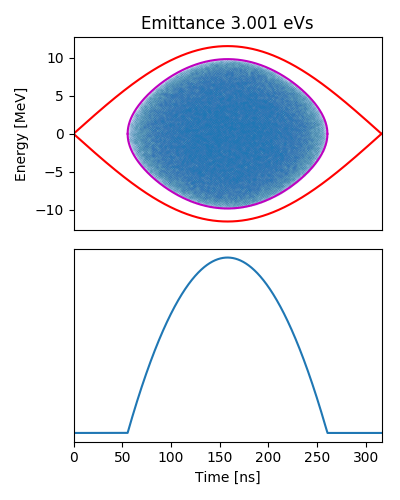

In [15]:
# Output figure

plt.figure('Beam', figsize=(4,5))
plt.clf()

plt.subplot(211)
plt.plot(beam.dt*1e9, beam.dE/1e6, '.',
         markersize=0.1, alpha=0.2)
plt.plot(time_bunch*1e9, dEbunch/1e6, 'm')
plt.plot(time_bunch*1e9, -dEbunch/1e6, 'm')
plt.plot(time_sep*1e9, dEsep/1e6, 'r')
plt.plot(time_sep*1e9, -dEsep/1e6, 'r')
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('Energy [MeV]')
plt.title('Emittance %.3f eVs'%(calc_area_bunch))

plt.subplot(212)
plt.plot(output_profile[0]*1e9, output_profile[1])
plt.xlim((0, rf_station.t_rf[0,0]*1e9))
plt.gca().get_yaxis().set_visible(False)
plt.xlabel('Time [ns]')

plt.tight_layout()
plt.savefig('figure_'+str(beam_selection)+'.png')



In [7]:
# Saving distribution

particle_beta = np.sqrt(1-(beam.Particle.mass/(beam.energy+beam.dE))**2.)

particle_z = -(beam.dt - rf_station.t_rf[0,0]/2.)*particle_beta*c

np.savez('distribution_'+str(beam_selection)+'.npz',
         dt=(beam.dt - rf_station.t_rf[0,0]/2.),
         dz=particle_z,
         dE=beam.dE)



In [9]:
# Load distribution and check columns

npzfile = np.load('distribution_BCMS.npz')
npzfile.files

['dt', 'dz', 'dE']

<IPython.core.display.Javascript object>


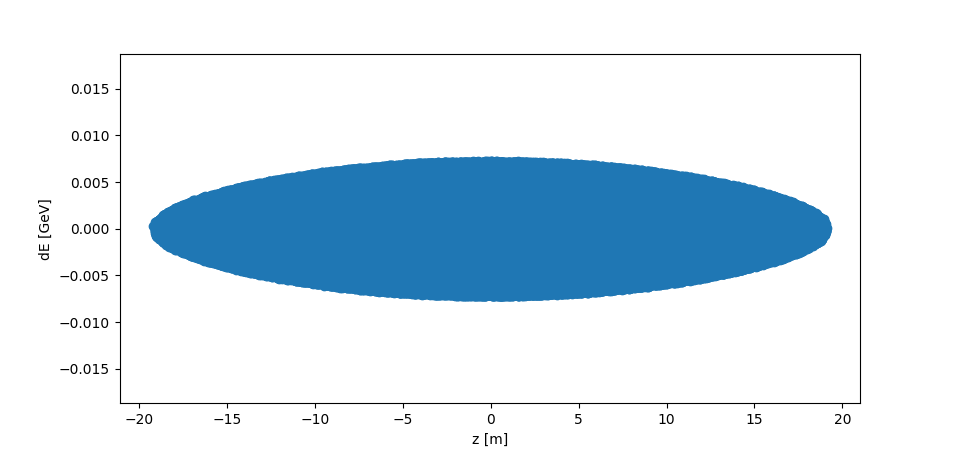

Text(0.5, 0, 'z [m]')

In [31]:
plt.figure('File', figsize=(4,4))
plt.clf()

plt.subplot(111)
plt.scatter(npzfile['dz'], npzfile['dE']/1E9)

plt.ylabel('dE [GeV]')
plt.xlabel('z [m]')

<IPython.core.display.Javascript object>


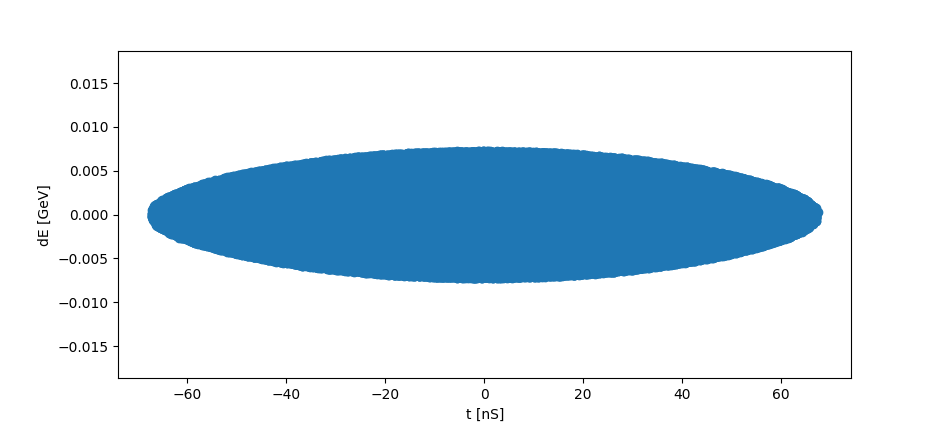

In [29]:
plt.figure(figsize=(4,4))
plt.clf()

plt.subplot(111)
plt.scatter(npzfile['dt']*1E9, npzfile['dE']/1E9)
plt.ylabel('dE [GeV]')
plt.xlabel('t [nS]')


plt.show()